In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке. Если в итоге по каким-то причинам тетрадка не будет открываться у преподавателя, задание не будет засчитано
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [108]:
# !pip install gdown
#!gdown 18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0 -O data.csv

Downloading...
From: https://drive.google.com/uc?id=18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0
To: /Users/bulatgumerov/Documents/GitHub/ml-fall22/09. Decision Trees/data.csv
100%|██████████████████████████████████████| 30.0M/30.0M [00:03<00:00, 8.99MB/s]


In [109]:
df = pd.read_csv('data.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [110]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

### Посмотрим на данные

In [111]:
df.head()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...


### Количество пропусков

In [112]:
df.isna().sum()

manufacturer                           5
price                                  0
number_available_in_stock           2211
number_of_reviews                     15
number_of_answered_questions         673
average_review_rating                 15
amazon_category_and_sub_category     550
dtype: int64

### Процент пропусков

In [113]:
df.isna().sum() / df.shape[0] * 100

manufacturer                         0.058500
price                                0.000000
number_available_in_stock           25.868726
number_of_reviews                    0.175500
number_of_answered_questions         7.874108
average_review_rating                0.175500
amazon_category_and_sub_category     6.435006
dtype: float64

1. manufacturer - заполним "unknown" на следующем шаге и переведем в категориальный признак
2. number_available_in_stock - количество_отвеченных_вопросов, заполним пропуски 0 на следующем шаге
3. number_of_reviews - количество просмотров, заполним 0 на следующем шаге
4. number_of_answered_questions - количество_отвеченных_вопросов, заполним 0 на следующем шаге
5. average_review_rating - усреднение_просмотров_рейтинг, удалим строки с пропусков в данной колонке
6. amazon_category_and_sub_category - амазон_категория_и_суб_категория, заполним "unknown" и переведем в категориальный

Заполнение 0 или "unknown" происходит, потому что:
* в количественных столбцах пропуски означают отсутствие данного признака, следовательно, можем использовать 0
* в категориальных заполним константой "unknown"

In [114]:
df['manufacturer'] = df['manufacturer'].fillna("unknown")
df['number_available_in_stock'] = df['number_available_in_stock'].fillna(0)
df['number_of_reviews'] = df['number_of_reviews'].fillna(0)
df['number_of_answered_questions'] = df['number_of_answered_questions'].fillna(0)
df['amazon_category_and_sub_category'] = df['amazon_category_and_sub_category'].fillna("unknown")

df = df.dropna()

Проверим

In [115]:
df.isna().sum()

manufacturer                        0
price                               0
number_available_in_stock           0
number_of_reviews                   0
number_of_answered_questions        0
average_review_rating               0
amazon_category_and_sub_category    0
dtype: int64

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

Пропуски в данных, были заполнены выше

In [116]:
df.head()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,0,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,0,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,0,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8532 entries, 0 to 8546
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   manufacturer                      8532 non-null   object 
 1   price                             8532 non-null   object 
 2   number_available_in_stock         8532 non-null   object 
 3   number_of_reviews                 8532 non-null   object 
 4   number_of_answered_questions      8532 non-null   float64
 5   average_review_rating             8532 non-null   object 
 6   amazon_category_and_sub_category  8532 non-null   object 
dtypes: float64(1), object(6)
memory usage: 533.2+ KB


### 3.1 Работа с числовыми данными

Переведем price в числовой тип данных

In [118]:
df['price'] = df['price'].str.replace('£', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype('float')
df['price'].max()

2439.92

Переведем number_available_in_stock в числовой тип данных

In [119]:
df['number_available_in_stock'] = df['number_available_in_stock'].replace('new', '', regex=True)
df['number_available_in_stock'] = df['number_available_in_stock'].replace('used', '', regex=True)
df['number_available_in_stock'] = df['number_available_in_stock'].replace('refurbished', '', regex=True)
df['number_available_in_stock'] = df['number_available_in_stock'].replace('collectible', '', regex=True)

df['number_available_in_stock'] = df['number_available_in_stock'].astype('uint8')
df['number_available_in_stock'].max()

92

change data type of number_of_reviews to int

In [120]:
df['number_of_reviews'] = df['number_of_reviews'].str.replace(',', '')
df['number_of_reviews'] = df['number_of_reviews'].astype('uint16')
df['number_of_reviews'].max()

1399

change data type of number_of_answered_questions to int

In [121]:
df['number_of_answered_questions'] = df['number_of_answered_questions'].astype('uint8')
df['number_of_answered_questions'].max()

39

change data type of average_review_rating to float

In [122]:
df['average_review_rating'] = df['average_review_rating'].replace('out of 5 stars', '', regex=True)
df['average_review_rating'] = df['average_review_rating'].astype('float')
df['average_review_rating'].max()

5.0

### 3.2. Работа с категориальными данными
cтолбец manufacturer

In [123]:
df['manufacturer'].value_counts()

Oxford Diecast        152
LEGO                  138
Disney                136
Playmobil             117
The Puppet Company    102
                     ... 
Noris                   1
Mammut                  1
M Gordon & Sons         1
Stephens                1
Green Hornet            1
Name: manufacturer, Length: 2358, dtype: int64

2358 - количество уникальных значений, прямое кодирование (One-Hot Encoding, OHE) для данного столбца не подойдет,
тк добавлять 2358 столбцов не целесообразно. Используем порядковое кодирование (Ordinal Encoding)

In [124]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df_new_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

df['manufacturer'] = df_new_ordinal['manufacturer']
df['manufacturer'] = df['manufacturer'].astype('float')

column amazon_category_and_sub_category

In [125]:
df['amazon_category_and_sub_category'].value_counts()

Die-Cast & Toy Vehicles > Toy Vehicles & Accessories > Scaled Models > Vehicles    784
unknown                                                                            545
Figures & Playsets > Science Fiction & Fantasy                                     359
Arts & Crafts > Children's Craft Kits > Bead Art & Jewellery-Making                340
Characters & Brands > Disney > Toys                                                292
                                                                                  ... 
Electronic Toys > Kids Remote & App Controlled Toys                                  1
Characters & Brands > Harry Potter > Books > Stationery                              1
Games > Casino Equipment > Game Sets > Roulette Sets                                 1
Games > Casino Equipment > Game Layouts > Poker Layouts                              1
Games > Drinking Games                                                               1
Name: amazon_category_and_sub_category, Len

Разобьем данный столбец на 3 столбца (иерархия категорий)

In [126]:
new_df = df['amazon_category_and_sub_category'].str.split('>', expand=True)
new_df

,0,1,2,3,4
0,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
1,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
2,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
3,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
4,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,None
...,...,...,...,...,...
8542,Hobbies,Collectible Figures & Memorabilia,Collectible Props & Memorabilia,None,None
8543,Characters & Brands,Star Wars,Toys,None,None
8544,Novelty & Special Use,Novelty,Accessories,Buttons & Pins,None
8545,Hobbies,Collectible Figures & Memorabilia,Collectible Props & Memorabilia,None,None


Закодируем каждый из полученных столбцов используя порядковое кодирование (Ordinal Encoding)

In [127]:
encoder = OrdinalEncoder()

df_new_ordinal = pd.DataFrame(encoder.fit_transform(new_df), columns=new_df.columns)
df_new_ordinal

,0,1,2,3,4
0,17.0,93.0,78.0,38.0,4.0
1,17.0,93.0,78.0,38.0,4.0
2,17.0,93.0,78.0,38.0,4.0
3,17.0,93.0,78.0,38.0,4.0
4,17.0,93.0,78.0,38.0,4.0
...,...,...,...,...,...
8527,17.0,33.0,31.0,44.0,4.0
8528,5.0,128.0,101.0,44.0,4.0
8529,26.0,94.0,1.0,4.0,4.0
8530,17.0,33.0,31.0,44.0,4.0


Добавим столбцы к исходному df

In [128]:
df = df.drop(columns=['amazon_category_and_sub_category'])
df = pd.concat([df, df_new_ordinal], axis=1)
df.head()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,0,1,2,3,4
0,932.0,3.42,5.0,15.0,1.0,4.9,17.0,93.0,78.0,38.0,4.0
1,721.0,16.99,0.0,2.0,1.0,4.5,17.0,93.0,78.0,38.0,4.0
2,2267.0,9.99,2.0,17.0,2.0,3.9,17.0,93.0,78.0,38.0,4.0
3,932.0,39.99,0.0,1.0,2.0,5.0,17.0,93.0,78.0,38.0,4.0
4,932.0,32.19,0.0,3.0,2.0,4.7,17.0,93.0,78.0,38.0,4.0


### 3.3. Ответ на дополнительные вопросы
1. *Какие из признаков в этом датасете лучше кодировать через ordinal encoding?* признаки в которых много уникальных значений
2. *Какие из признаков допустимо кодировать через one-hot?* признаки в которых немного уникальных значений

In [129]:
df = df.dropna()

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [130]:
import warnings
warnings.filterwarnings('ignore')

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

X, y = df.drop(columns=['price']), df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=42)
#X_train = Normalizer().fit_transform(X_train)
#X_test = Normalizer().fit_transform(X_test)

In [152]:
from sklearn.dummy import DummyRegressor


dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.predict(X_test)
None

In [153]:
# Проверьте качество бейзлайна
dummy.score(X_test, y_test)

-0.0011482402730911279

Качество получилось очень плохое (

## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [154]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse

Обучим модель

In [155]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
None

Измерим качество

In [156]:
y_pred = regressor.predict(X_test)
model_r2_score = r2_score(y_test, y_pred)
model_mean_squared_error = mse(y_test, y_pred)

print('model_r2_score =', model_r2_score)
print('model_mean_squared_error =', model_mean_squared_error)

model_r2_score = -3.5102073393145217
model_mean_squared_error = 6395.950529681227


Модель очень ошибается

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [137]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [138]:
model_r2_score = r2_score(y_test, y_pred)
print('model_r2_score =', model_r2_score)

model_r2_score = 0.02571087925103621


Дела обстоят уже лучше, намного лучше чем лес

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [139]:
import seaborn as sns


def plot_fitting_curve(parameter: str, values: list, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        model = DecisionTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    val, idx = min((val, idx) for (idx, val) in enumerate(test_curve))
    print(f'Лучший {parameter} на тестовых данных:', idx+1)
    sns.lineplot(x=values, y=train_curve, label="Train").set_title(parameter)
    sns.lineplot(x=values, y=test_curve, label="Test")

Глубина дерева

Лучший max_depth на тестовых данных: 2


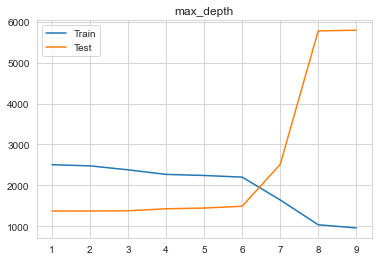

In [157]:
plot_fitting_curve('max_depth', np.arange(1, 10), X_train, X_test, y_train, y_test)

Минимальное количество образцов, необходимое для разделения

Лучший min_samples_split на тестовых данных: 99


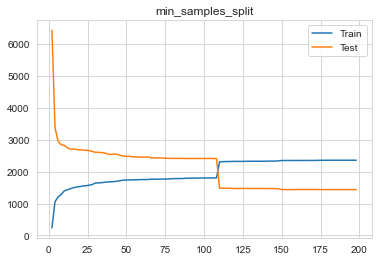

In [162]:
plot_fitting_curve('min_samples_split', np.arange(2, 200, 2), X_train, X_test, y_train, y_test)

Минимальное количество образцов, необходимое для нахождения в листовом узле

Лучший min_samples_leaf на тестовых данных: 9


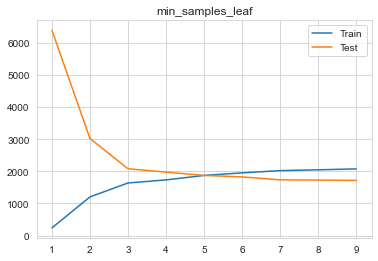

In [158]:
plot_fitting_curve('min_samples_leaf', np.arange(1, 10), X_train, X_test, y_train, y_test)

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [143]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]

    def fit(self, x: pd.DataFrame, y: pd.Series):
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)

    def predict(self, x: pd.DataFrame):
        # В качестве предсказания ансамбля будем выдавать усреднение предсказаний деревьев
        tree_y_pred = np.zeros((x.shape[0]))
        num_trees = 0
        for tree in self._trees:
            num_trees += 1
            tree_y_pred += tree.predict(x)
            print(tree_y_pred)

        print(tree_y_pred / num_trees)
        return tree_y_pred / num_trees

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

## Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

In [144]:
ensemble =  EnsembleTreeRegressor()
ensemble.fit(X_train, y_train)
print('MSE Ensemble:', mse(y_test, ensemble.predict(X_test)))

[  2.99   4.09   5.99 ...  24.95 166.04   3.59]
[  5.98   8.18  11.98 ...  49.9  261.84   7.18]
[  8.97  12.27  17.97 ...  74.85 427.88  10.77]
[ 11.96  16.36  23.96 ...  99.8  593.92  14.36]
[ 14.95  20.45  29.95 ... 124.75 759.96  17.95]
[  2.99    4.09    5.99  ...  24.95  151.992   3.59 ]
MSE Ensemble: 4330.516068193055


Качество получилось примерно одинаковое